In [1]:
%%capture
try:
    import pandas
except ImportError as e:
    !pip install pandas 

try: 
    import numpy
except ImportError as e:
    !pip install numpy 

try:
    import matplotlib
except ImportError as e:
    !pip install matplotlib 

try:
    import sklearn
except ImportError as e:
    !pip install scikit-learn

try:
    import scipy
except ImportError as e:
    !pip install scipy

try:
    import statsmodels
except ImportError as e:
    !pip install statsmodels

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse
import statsmodels.api as sm
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA

## Model Configuration

In [21]:
context_len = 512
forecast_len = 1
STRIDE = 1
ALPHA = 0.9
NUM_PLOTS = 5

## Loading Data

In [8]:
data = ETTh1[['OT']].values
scaler = StandardScaler()
train_data = data[border1s[0]:border2s[0],:]
scaler = StandardScaler()
scaler.fit(train_data)
# print(scaler.mean_)
# print(scaler.var_)
data = scaler.transform(data)
valid_data = data[border1s[1]:border2s[1],:]
test_data = data[border1s[2]:border2s[2],:]

## Implements EMA


In [9]:
def get_ema_forecast(context, alpha=ALPHA):
    s_t = context[0,:]
    for t in range(1, context.shape[0]):
        s_t = alpha * context[t,:] + (1-alpha) * s_t
    return s_t
        

In [10]:
summary = []
for idx, _ in enumerate(test_data):
    if idx+context_len+forecast_len < test_data.shape[0]:
        context = test_data[idx:idx+context_len,:]
        actual = test_data[idx+context_len:idx+context_len+forecast_len,:]
        forecast = get_ema_forecast(context)
        summary.append((context, actual, np.array([forecast])))

In [11]:
actual = [i[1][0,0] for i in summary]
forecast = [i[2][0,0] for i in summary]

In [12]:
print(np.round(mse(actual,forecast),5))

0.00417


In [13]:
random_indices = np.random.choice(len(summary), size=NUM_PLOTS, replace=False)

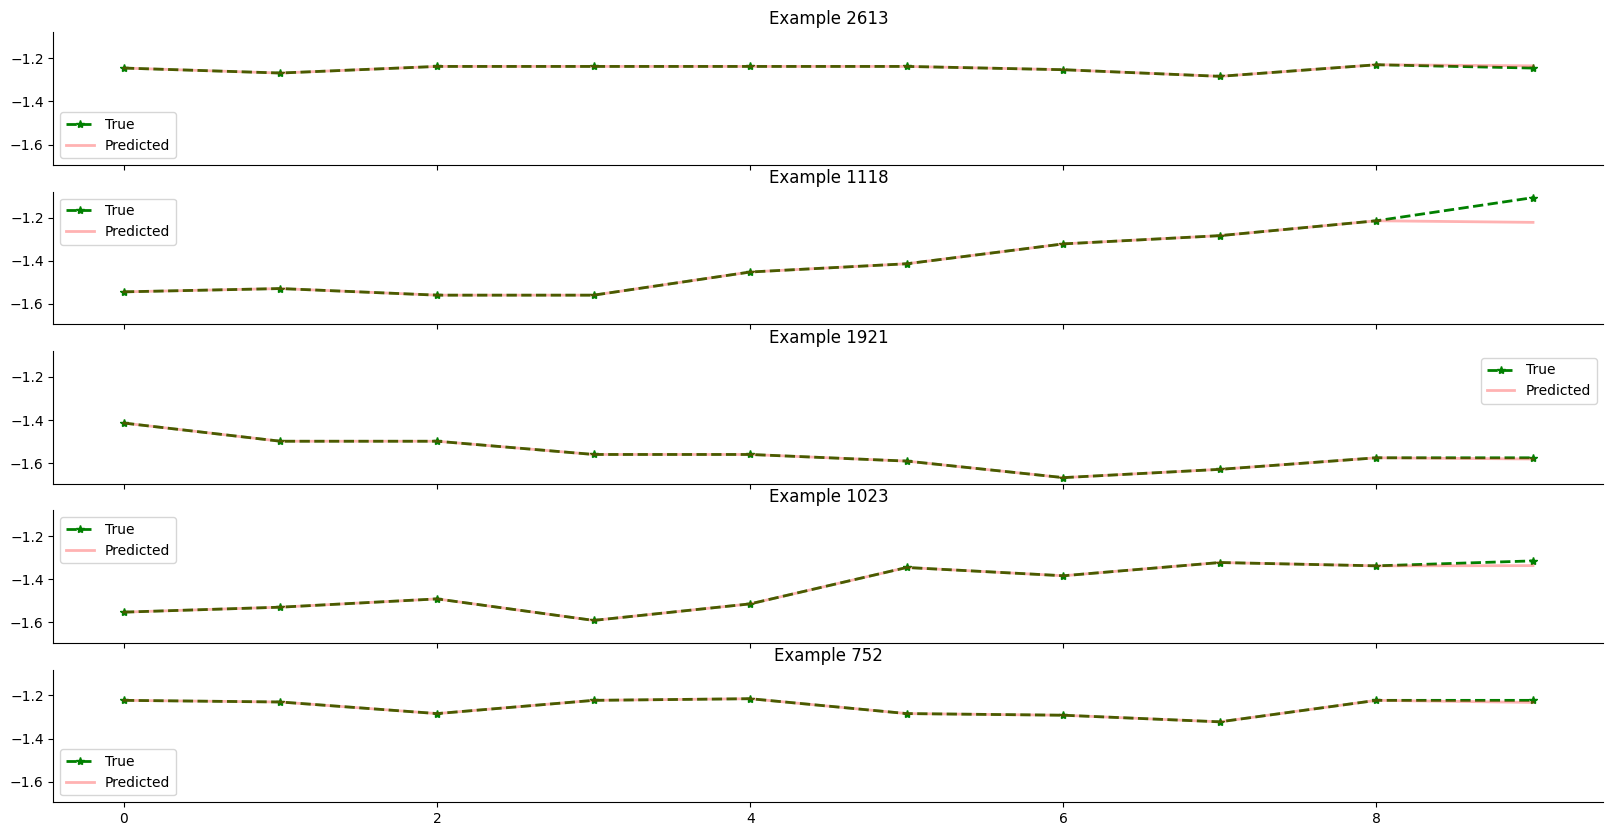

In [14]:
last_pts = 10
fig, axs = plt.subplots(len(random_indices), 1, sharex='col', sharey=True, figsize=(20,len(random_indices)*2))
for i, ri in enumerate(random_indices):
    act = np.concatenate((summary[ri][0],summary[ri][1]), axis=0)
    fcast = np.concatenate((summary[ri][0],summary[ri][2]),axis=0)
    axs[i].plot(act[-last_pts:,:], label="True", linestyle='--', marker='*', color='green', linewidth=2)
    axs[i].plot(fcast[-last_pts:,:], label="Predicted", linestyle='-', color='red', linewidth=2, alpha=0.3 )
    axs[i].set_title(f'Example {random_indices[i]}')
    # axs[i].set_ylim(-3, 3)
    for s in ['top', 'right']:
        axs[i].spines[s].set_visible(False)
    axs[i].legend()

## ARMA on ETT Dataset

In [15]:
def get_arma_forecast(context, p=1, r=0, q=0):
    arma = ARIMA(context, order=(p, r, q)).fit(method_kwargs={"warn_convergence": False})
    predict_etth1_ot = arma.predict(context.shape[0]+1, context.shape[0]+1)
    return predict_etth1_ot
        

In [16]:
context_len = 512
arma_summary = []
for idx, _ in enumerate(test_data):
    if idx+context_len+forecast_len < test_data.shape[0]:
        context = test_data[idx:idx+context_len,:]
        actual = test_data[idx+context_len:idx+context_len+forecast_len,:]
        forecast = get_arma_forecast(context)
        arma_summary.append((context, actual, np.array([forecast])))
        if idx%100==0:
            print(f'# of forecasts so far {idx}', actual[0,0], forecast[0])

# of forecasts so far 0 -0.8623406838331442 -0.884013147748147
# of forecasts so far 100 -0.7702575264768241 -0.78028476341486
# of forecasts so far 200 -0.7550012167100648 -0.8598067465374787
# of forecasts so far 300 -1.1382631533225331 -1.1406436505985043
# of forecasts so far 400 -0.6706552324179509 -0.7122657545688613
# of forecasts so far 500 -0.7166423020056977 -0.7355726938438489
# of forecasts so far 600 -1.8665371819868368 -1.6863142217916807
# of forecasts so far 700 -1.2456026724085205 -1.2164668396144307
# of forecasts so far 800 -1.0462890141470393 -1.11211497054126
# of forecasts so far 900 -1.552255823774535 -1.5196141459963934
# of forecasts so far 1000 -1.2302372924980267 -1.191833994158338
# of forecasts so far 1100 -1.421922795876128 -1.430993305834501
# of forecasts so far 1200 -1.6442299889314824 -1.6303874106692624
# of forecasts so far 1300 -1.5752493585684082 -1.5248884226933581
# of forecasts so far 1400 -1.3911920880180484 -1.3885987850069044
# of forecasts s

In [17]:
arma_actual = [i[1][0,0] for i in arma_summary]
arma_forecast = [i[2][0,0] for i in arma_summary]

In [18]:
print(np.round(mse(arma_actual,arma_forecast),5))

0.00425


In [19]:
arma_random_indices = np.random.choice(len(arma_summary), size=NUM_PLOTS, replace=False)

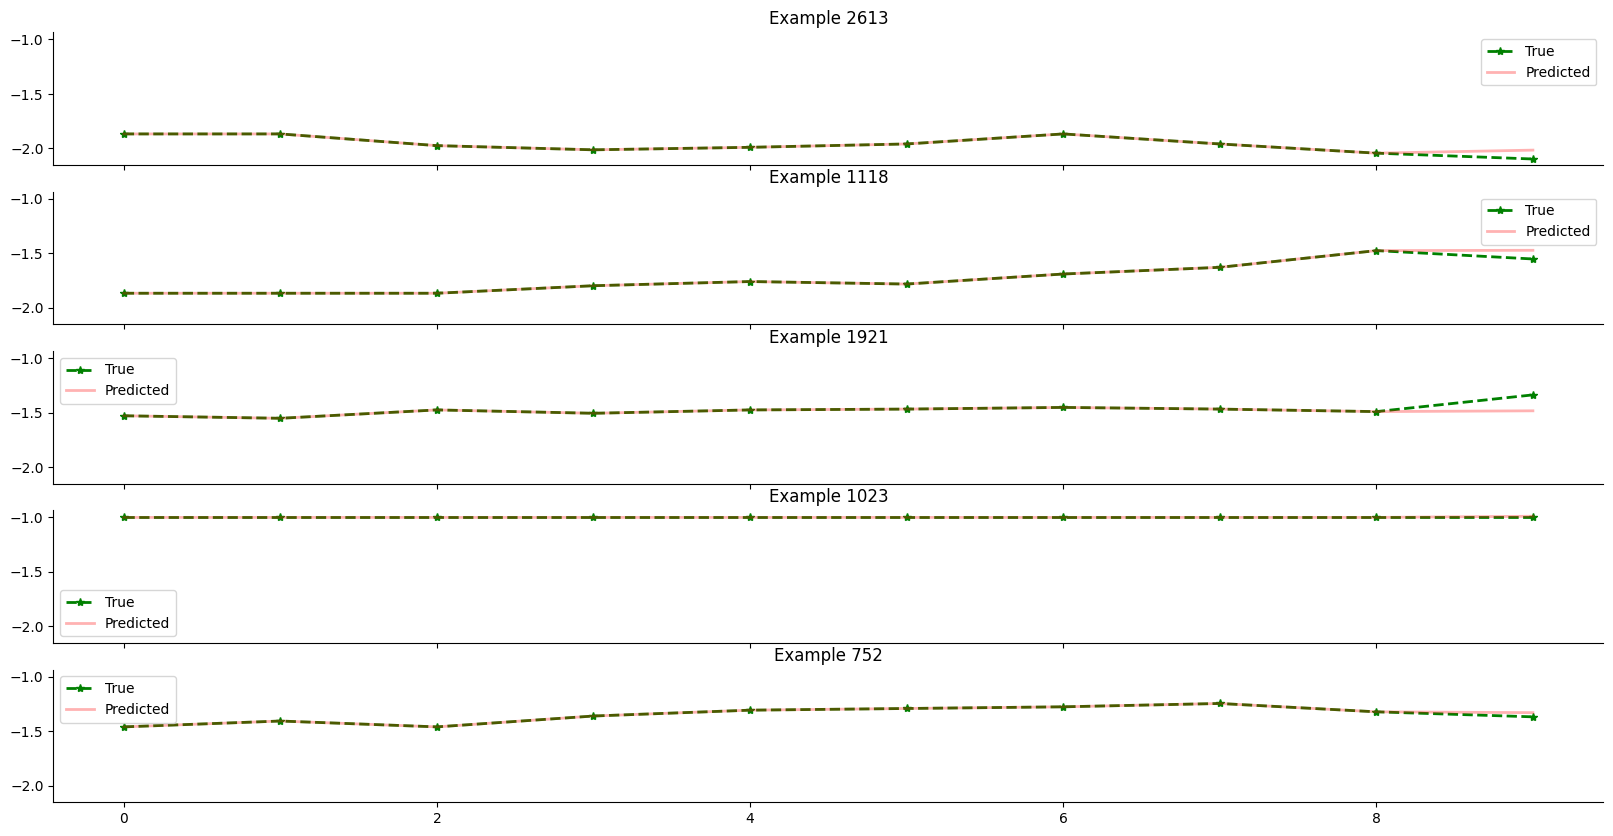

In [20]:
fig, axs = plt.subplots(len(arma_random_indices), 1, sharey=True, sharex='col', figsize=(20,len(arma_random_indices)*2))
for i, ri in enumerate(arma_random_indices):
    act = np.concatenate((arma_summary[ri][0],arma_summary[ri][1]), axis=0)
    fcast = np.concatenate((arma_summary[ri][0],arma_summary[ri][2]),axis=0)
    axs[i].plot(act[-last_pts:,:], label="True", linestyle='--', color='green', marker='*', linewidth=2)
    axs[i].plot(fcast[-last_pts:,:], label="Predicted", linestyle='-', color='red', linewidth=2, alpha=0.3 )
    axs[i].set_title(f'Example {random_indices[i]}')
    # axs[i].set_ylim(-3, 3)
    for s in ['top', 'right']:
        axs[i].spines[s].set_visible(False)
    axs[i].legend()